In [2]:
import numpy as np
import random
import os
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt
from keras import backend as K
from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


# 1D Ising chain energy minimization with Deep Q-learning

The Ising model is a simple model, which can be mapped to many real physical systems. Typically it is used to model phase transitions of magnetic materials. Imagine a chain of N particles, each interacting with its nearest neighbours. The Hamiltonian (energy) of this system is given by

$$H = J \sum_{i=1}^{N-1} \sigma_i\sigma_{i+1}$$

Here $\sigma_i$ is the spin of particle i, which can take values $\sigma_i = \pm 1$. J is an interaction parameter, which determines wheter the spins want to align or anti-align. A simple example is a chain of $N=3$ spins, which is described by

$$ H = J (\sigma_1\sigma_2 + \sigma_2\sigma_3) $$

If $J>0$, the equilibrium state (which is the minium energy state), is one where all the spins are anti-aligned with its nearest neighbours. E.g., if $J = 1$, one of the minimums of H is the configuration $\sigma_1 = 1$, $\sigma_2 = -1$ and $\sigma_3 = 1$.

$$ H_{min} = 1\cdot(1\cdot-1 + -1\cdot1) = -2 $$

While if $J<0$ the energy minimum is when the spins are aligned. E.g., if $J= -1$, then one of the energy minima is found when the spin configuration is $\sigma_1 = \sigma_2 = \sigma_3 = 1$

$$H_{min} = -1\cdot(1\cdot1 + 1\cdot1 ) = -2$$

![title](figs/ising_ex.png)

We see that depending on the sign of $J$, the energy minima is either a parallel or an anti-parallel alignment of the spins.

Usually, introduction to Deep Q-learning is done by using openai gym, in environments like cartpole and mountaincar. I think this system is much simpler, and can be used to illustrate some imporant features of Q-learning. This guide is meant for those who have some experience in reinforcement learning, as I will not go through details of the algorithm. There are many good reasources online where you can read about Deep-Q learning, which is the algorithm used here.

The goal is to minimize the energy of a 1D chain of spins, in as few steps as possible, by letting the agent choose which spin to flip each step. The episode ends when the energy minima is found, or when the maximum number of spin flips is performed.

# Spin chain enviornment
Here we define the enironment that the agent will interact with. It takes as input only the number of spins in the chain.

In [3]:
class spin_chain_env:
    
    def __init__(self,N):
        self.N = N  # Number of chained spins
        self.action_space = np.zeros(self.N)
        self.observation_space = np.zeros(self.N)
        self.max_steps = self.N # Set the maximum number of steps before episode end.
        
        
    # After each episode, the state is reset to a random configuration of spins.
    # The state is just the spin configuration, which is an array of +1 and -1.
    def reset(self):
        self.state = np.array([random.choice([-1,1]) for n in range(self.N) ])
        self.cum_reward = 0
        self.steps = 0
        return self.state
    
    def step(self,action):
        self.steps +=1
        
        # The action is to choose a spin in the chain, and flip it, i.e. -1 -> 1, and 1 -> -1
        self.state[action] = -1*self.state[action]
        
        # If J is negative, the minimum is ferromagnetic (anti-aligned), 
        # and if positive it is antiferromagnetic (alinged)
        
        J = 1
        
        # Here we calculate the energy, which we want to minimize
        energy = np.sum([J*self.state[n]*self.state[n+1] for n in range(self.N-1)]) 
        #energy += J*self.state[0]*self.state[self.N-1] ## Enable for periodic boundary conditions.
        
        
        min_energy = -(self.N-1)*abs(J) #This is the minimum energy state for a 1D chain of N spins. 
        
        # If the energy minimum is found we end the episode, and give the energy as reward.
        # If we reach the maximum number of allowed steps, we end the episode.
        # Every step, we give a reward (punishment) of -1, so that the agent is encouraged to use as few steps as poissible
        # to minimize the energy
        
        if energy == min_energy:
            done = True
            reward = -energy
            self.cum_reward += reward

        elif self.steps == self.max_steps:
            done = True
            reward = -1
            self.cum_reward += reward     
        else:
            done = False
            reward = -1
            self.cum_reward += reward
        
        return np.array(self.state), reward, done, {}

## Some comments on the environment

If we didnt give some negative reward for each step, the agents learning would drastically slow down. It would still be able to find the energy minima, but it would not care how fast it got there. The agent would consider experiences where the spins are unnessecarily flipped twice, and those where the energy is minimized in as few flips as possible, equally good choices, as long as the minimum energy is eventually reached

# Agent 
Here we define the agent that will interact with the environment. It consists of a neural network, which is used to learn the optimal Q-value for all action-state pairs.

In [4]:
class Agent:
    
    # Initialize the agent with common hyperparameters
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen = 10000) # Size of the experience replay memory
        
        self.gamma = 1.0  # We have added a negative reward for each time step
                          # so there is no need to set the discount below 1
            
        self.epsilon = 1.0 # Initial exploration rate
        
        # The epsilon decay and epsilon min are redefined later, based on the total number of episodes.
        self.epsilon_decay = 0.99995 
        self.epsilon_min = 0.01
        
        self.learning_rate = 0.001        
        
        self.model = self._build_model()
        self.target_model = self._build_model()
    
    # Here we build the neural network, which will predict the best action based on the state
    def _build_model(self):
        
        model = Sequential()
        
        model.add(Dense(12, input_dim = self.state_size, activation = 'relu'))
        model.add(Dense(24, activation = 'relu'))
        model.add(Dense(12, activation = 'relu'))
        model.add(Dense(self.action_size, activation = 'linear'))
        
        model.compile(loss='mse', optimizer = Adam(lr = self.learning_rate))
        
        return model
    
    # Store experiences in a replay memory
    def remember(self, state, action, reward, next_state, done):
        
        self.memory.append((state, action, reward, next_state, done))
     
    # Here the network chooses an action to perform. If a randomly generated number is less than epsilon
    # a random action is taken, and if its larger, the action that the agent think is best is performed.
    def act(self,state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    # Here the neural network is updated based on random samples of experiences from the replay memory
    def replay(self, batch_size):
        
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            
            target = self.target_model.predict(state)
            
            if done:
                target[0][action] = reward
                
            else:
                Q_future = max(self.target_model.predict(next_state)[0])
                target[0][action] = reward + Q_future*self.gamma
                
            self.model.fit(state, target, epochs = 1, verbose = 0)    
    
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self,name):
        self.model.save_weights(name)
        

In [107]:
Q1 = np.array([])
Q2 = np.array([])
score = np.array([])

In [108]:
n_spins = 4
env = spin_chain_env(n_spins)
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('State size: {}'.format(state_size))
print('Action size: {}'.format(action_size))

State size: 4
Action size: 4


In [109]:
batch_size = 32
n_episodes = 1000
tau = 1e-2

agent = Agent(state_size, action_size)
agent.epsilon_decay = (0.05)**(1/n_episodes)
agent.memory = deque(maxlen = 1000)
agent = Agent(state_size, action_size)

In [110]:
agent.epsilon_decay = (0.05)**(1/n_episodes)
agent.memory = deque(maxlen = 1000)
agent.epsilon = 1.0

To study the agents performance, we store its estimation of the Q-function of a trial state every episode.

In [111]:
done = False

test_state1 = [1,1,1,1] # We record the agents prediction of the Q-function of this state
test_state1 = np.reshape(test_state1,[1,state_size])


test_state2 = [1,-1,1,1] # We record the agents prediction of the Q-function of this state
test_state2 = np.reshape(test_state2,[1,state_size])

for e in range(n_episodes):
    
    state = env.reset()
    state = np.reshape(state, [1,state_size])
    
    for t in range(env.max_steps):
        
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1,state_size])
        
        agent.remember(state, action, reward, next_state, done)
        
        state = next_state
        
        if done:
            print('episode: {}/{}, score: {}, epsilon: {:.2}'.format(e,n_episodes, env.cum_reward, agent.epsilon))
            score = np.append(score,env.cum_reward)
            Q1 = np.append(Q1,agent.model.predict(test_state1)[0])
            Q2 = np.append(Q2,agent.model.predict(test_state2)[0])

            break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

            target_weights = np.array(agent.target_model.get_weights())
            current_weights = np.array(agent.model.get_weights())

            agent.target_model.set_weights(current_weights*tau + target_weights*(1-tau))
        
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay



episode: 0/1000, score: -4, epsilon: 1.0
episode: 1/1000, score: -4, epsilon: 1.0
episode: 2/1000, score: -4, epsilon: 0.99
episode: 3/1000, score: -4, epsilon: 0.99
episode: 4/1000, score: -4, epsilon: 0.99
episode: 5/1000, score: -4, epsilon: 0.99
episode: 6/1000, score: 0, epsilon: 0.98
episode: 7/1000, score: 2, epsilon: 0.98
episode: 8/1000, score: -4, epsilon: 0.98
episode: 9/1000, score: -4, epsilon: 0.97
episode: 10/1000, score: -4, epsilon: 0.97
episode: 11/1000, score: 2, epsilon: 0.97
episode: 12/1000, score: -4, epsilon: 0.96
episode: 13/1000, score: -4, epsilon: 0.96
episode: 14/1000, score: 3, epsilon: 0.96
episode: 15/1000, score: 3, epsilon: 0.96
episode: 16/1000, score: 3, epsilon: 0.95
episode: 17/1000, score: -4, epsilon: 0.95
episode: 18/1000, score: -4, epsilon: 0.95
episode: 19/1000, score: 3, epsilon: 0.94
episode: 20/1000, score: 2, epsilon: 0.94
episode: 21/1000, score: 2, epsilon: 0.94
episode: 22/1000, score: -4, epsilon: 0.94
episode: 23/1000, score: 1, epsi

episode: 193/1000, score: -4, epsilon: 0.56
episode: 194/1000, score: 1, epsilon: 0.56
episode: 195/1000, score: 1, epsilon: 0.56
episode: 196/1000, score: -4, epsilon: 0.56
episode: 197/1000, score: 0, epsilon: 0.55
episode: 198/1000, score: 3, epsilon: 0.55
episode: 199/1000, score: 0, epsilon: 0.55
episode: 200/1000, score: 0, epsilon: 0.55
episode: 201/1000, score: 2, epsilon: 0.55
episode: 202/1000, score: 3, epsilon: 0.55
episode: 203/1000, score: 2, epsilon: 0.54
episode: 204/1000, score: -4, epsilon: 0.54
episode: 205/1000, score: 3, epsilon: 0.54
episode: 206/1000, score: 1, epsilon: 0.54
episode: 207/1000, score: -4, epsilon: 0.54
episode: 208/1000, score: 1, epsilon: 0.54
episode: 209/1000, score: 2, epsilon: 0.53
episode: 210/1000, score: 3, epsilon: 0.53
episode: 211/1000, score: 2, epsilon: 0.53
episode: 212/1000, score: 3, epsilon: 0.53
episode: 213/1000, score: 2, epsilon: 0.53
episode: 214/1000, score: -4, epsilon: 0.53
episode: 215/1000, score: 2, epsilon: 0.53
episod

episode: 384/1000, score: 1, epsilon: 0.32
episode: 385/1000, score: 3, epsilon: 0.32
episode: 386/1000, score: 1, epsilon: 0.31
episode: 387/1000, score: 2, epsilon: 0.31
episode: 388/1000, score: 3, epsilon: 0.31
episode: 389/1000, score: 2, epsilon: 0.31
episode: 390/1000, score: 2, epsilon: 0.31
episode: 391/1000, score: 3, epsilon: 0.31
episode: 392/1000, score: 3, epsilon: 0.31
episode: 393/1000, score: 3, epsilon: 0.31
episode: 394/1000, score: 3, epsilon: 0.31
episode: 395/1000, score: 2, epsilon: 0.31
episode: 396/1000, score: 2, epsilon: 0.31
episode: 397/1000, score: 2, epsilon: 0.3
episode: 398/1000, score: 3, epsilon: 0.3
episode: 399/1000, score: 2, epsilon: 0.3
episode: 400/1000, score: 2, epsilon: 0.3
episode: 401/1000, score: 3, epsilon: 0.3
episode: 402/1000, score: 1, epsilon: 0.3
episode: 403/1000, score: 3, epsilon: 0.3
episode: 404/1000, score: 3, epsilon: 0.3
episode: 405/1000, score: 3, epsilon: 0.3
episode: 406/1000, score: 3, epsilon: 0.3
episode: 407/1000, sc

episode: 577/1000, score: 2, epsilon: 0.18
episode: 578/1000, score: 2, epsilon: 0.18
episode: 579/1000, score: 1, epsilon: 0.18
episode: 580/1000, score: 0, epsilon: 0.18
episode: 581/1000, score: 2, epsilon: 0.18
episode: 582/1000, score: 3, epsilon: 0.17
episode: 583/1000, score: 2, epsilon: 0.17
episode: 584/1000, score: 2, epsilon: 0.17
episode: 585/1000, score: 0, epsilon: 0.17
episode: 586/1000, score: 2, epsilon: 0.17
episode: 587/1000, score: 2, epsilon: 0.17
episode: 588/1000, score: 2, epsilon: 0.17
episode: 589/1000, score: 3, epsilon: 0.17
episode: 590/1000, score: 2, epsilon: 0.17
episode: 591/1000, score: 2, epsilon: 0.17
episode: 592/1000, score: 3, epsilon: 0.17
episode: 593/1000, score: 3, epsilon: 0.17
episode: 594/1000, score: 3, epsilon: 0.17
episode: 595/1000, score: 2, epsilon: 0.17
episode: 596/1000, score: 2, epsilon: 0.17
episode: 597/1000, score: 3, epsilon: 0.17
episode: 598/1000, score: 2, epsilon: 0.17
episode: 599/1000, score: 3, epsilon: 0.17
episode: 60

episode: 769/1000, score: 2, epsilon: 0.1
episode: 770/1000, score: 3, epsilon: 0.1
episode: 771/1000, score: 2, epsilon: 0.099
episode: 772/1000, score: 2, epsilon: 0.099
episode: 773/1000, score: 3, epsilon: 0.099
episode: 774/1000, score: 2, epsilon: 0.098
episode: 775/1000, score: 2, epsilon: 0.098
episode: 776/1000, score: 3, epsilon: 0.098
episode: 777/1000, score: 2, epsilon: 0.098
episode: 778/1000, score: -4, epsilon: 0.097
episode: 779/1000, score: 2, epsilon: 0.097
episode: 780/1000, score: 3, epsilon: 0.097
episode: 781/1000, score: 3, epsilon: 0.096
episode: 782/1000, score: 2, epsilon: 0.096
episode: 783/1000, score: 2, epsilon: 0.096
episode: 784/1000, score: 3, epsilon: 0.095
episode: 785/1000, score: 2, epsilon: 0.095
episode: 786/1000, score: 2, epsilon: 0.095
episode: 787/1000, score: 2, epsilon: 0.095
episode: 788/1000, score: 3, epsilon: 0.094
episode: 789/1000, score: 2, epsilon: 0.094
episode: 790/1000, score: 3, epsilon: 0.094
episode: 791/1000, score: 2, epsilo

episode: 957/1000, score: 2, epsilon: 0.057
episode: 958/1000, score: 1, epsilon: 0.057
episode: 959/1000, score: 2, epsilon: 0.057
episode: 960/1000, score: 3, epsilon: 0.056
episode: 961/1000, score: 3, epsilon: 0.056
episode: 962/1000, score: 2, epsilon: 0.056
episode: 963/1000, score: 2, epsilon: 0.056
episode: 964/1000, score: 3, epsilon: 0.056
episode: 965/1000, score: 3, epsilon: 0.056
episode: 966/1000, score: 3, epsilon: 0.055
episode: 967/1000, score: 3, epsilon: 0.055
episode: 968/1000, score: 3, epsilon: 0.055
episode: 969/1000, score: 3, epsilon: 0.055
episode: 970/1000, score: 3, epsilon: 0.055
episode: 971/1000, score: 3, epsilon: 0.055
episode: 972/1000, score: 2, epsilon: 0.054
episode: 973/1000, score: 3, epsilon: 0.054
episode: 974/1000, score: 3, epsilon: 0.054
episode: 975/1000, score: 2, epsilon: 0.054
episode: 976/1000, score: 2, epsilon: 0.054
episode: 977/1000, score: 2, epsilon: 0.054
episode: 978/1000, score: 2, epsilon: 0.053
episode: 979/1000, score: 2, eps

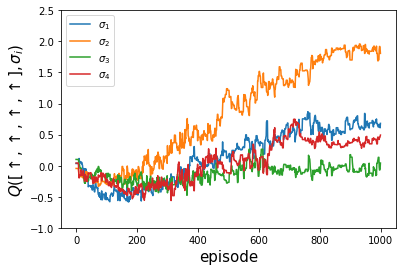

In [113]:
## Plot results for trial function

Q_plot = np.reshape(Q1,[-1,n_spins])
e = [n for n in range(Q_plot.shape[0])]

for n in range(state_size):
    plt.plot(e,Q_plot[:,n])

plt.legend([r"$\sigma_1$",r"$\sigma_2$",r"$\sigma_3$",r"$\sigma_4$"],fontsize = 10)
plt.xlabel("episode",fontsize = 15)
plt.ylabel(r"$Q([\uparrow,\uparrow,\uparrow,\uparrow],\sigma_i)$",fontsize = 15)
#for n in range(1,7):
#    plt.plot([n*1000,n*1000],[-3,3],color = 'black', linestyle = '--')
plt.ylim([-1, 2.5])
plt.savefig("figs/Q_new_new_retraining.png")

![title](figs/Q_new.png)

The correct action to perform on the trial state (with $J = +1$), is to flip the third spin, so that all of them are anti-aligned.

When we plot the agents estimation of the Q-function for the trial state, [$\uparrow,\downarrow,\downarrow$],
 we see that at the end of training, it estimates that the best action is to flip the $\sigma_3$ spin, which is correct.
 
Moreover, the Q-value of performing this action in this state is also correctly predicted. That is; the expected cumulative reward for this state-action pair is 2 (remember that the reward recieved upon energy minimization is $(N-1)|J| = 2$.

However, notice that its prediction of the expected cumulative reward for the two other actions are not correct. If the second spin is flipped, the agent can then just flip the first, which minimizes the energy (with all spins anti-aligned), resulting in a total reward of 1. A similar policy exists if the first spin is flipped.

It seems that the agent only estimates correctly the Q-function of the optimal policy, not any of the suboptimal ones. But this should not be a surprise, since the neural network is fitted by using the Bellman equation as the target, which is valid for the optimal policy only, not the full Q-function. 

## Network plasticity

![title](figs/Q_retraining_1.png)

Here we first train the agent to minimize the energy of the spin chain with $J = +1$. In this case the optimal action for the trial state is to flip the third spin, such that the spin configuration is anti-aligned. After 1000 episodes, the agent finds this optimal action, and accurately predicts the optimal Q-value of this action (2).

We then reset the exploration policy, empty the replay memory, and change the environment by setting $ J = -1$, such that the energy minimum is found when the spins are all aligned. However, we use the same network parameters (i.e., the weights and biases) that we obtained from training on the $J = +1$ environment.

The optimal action is now to flip the first spin, ($\sigma_1$). In the plot above, the point where we change the coupling $J$ is indicated by the black dashed line. As we can see, the value of flipping the third spin rapidly decreases, while the value of the two other actions rapidly increases. However, even 1000 episodes after the environment was changed, the network still predicts that the flipping the thrid spin ($\sigma_3$) is the best action, which is obviously wrong.

Again, this is no surprise, since when we change the environment, the agent have to solve a completely new problem, and the information it has about the previous problem is not useful for him. In fact, this result highlights the importance of having properly initialized networks. Essentially, after episode 1000, the agent starts learning a new problem, but the network parameters is very biased towards the old problem.

Even though the change from $J = +1 $ to $J=-1$ is two highly related problems for us, the agent does not know any physics, so he/she/it sees it as a completely different problem.

# First world problems

We now increase the number of spins to 4, and study the trial state $[\uparrow,\uparrow,\uparrow,\uparrow]$

By setting $J = +1$, the energy minimum is when the spins are anti-alinged. However, with the trial state defined above, it does not matter which spin is flipped first, since you have to flip two of them in order to reach the energy minimum. If the first spin is flipped, the next optimal action is to flip the thrird spin. If the second spin is flipped, the next optimal action is to flip the fourth spin, etc. Even though all actions are equally good, the agent has to choose one of them. What will it do?

![title](figs/Q_new_new_retraining.png)

It seems like the agent values flipping either spin 2 first. He/she/it cannot really decide which one to prefer. But it is clear that it thinks flipping the third spin first is a very bad action.

If this was a more complicated system, where we did not know the true optimal action (or actions in this case) and asked the agent what it thinks, it would confidently say that flipping spin number 2 is the best thing to do. Obviously this is not wrong, but its not exactly right either. The information that all the actions are equally good is lost in this case, and blindly trusting the agent could make you loose this valuable information about the system you're studying.

In this case the optimal policy for the trial state, really is ambigious. The reason the agent prefers flipping spin 2, is that by random chance, experiences where the agent has seen this configuration, the ones where spin 2 is flipped has lead to a larger reward than in other cases. That is, the experiences where the proceeding states (i.e., $[\uparrow,\downarrow,\uparrow,\uparrow]$, and $[\uparrow,\uparrow,\uparrow,\downarrow]$) have led to a higher reward (by random choices due to the exploration strategy). Or it can simply be that those experiences has been randomly drawn from the memory more often during training.

In order to help the agent realize that the four actions in the trial state is equally good, we can do the same reset as we did for the three spin scenario: We reset the exploration policy and empty the memory, and then start the training anew. If we do this many times in succession, we obtain the plot shown below.

![title](figs/Q_4spins_1.png)

Every 1000 episode, we perform the reset. For the first session of 1000 episodes, the agent favours flipping either spin 1 or spin 4 (in close contention), but after a series of resets, by around episode 5000-6000, the agent values all actions approximately equally. However, the estimation of the Q-value is wrong for all of them, it should actually be 

A unique thing about this trial state ($[\uparrow,\uparrow,\uparrow,\uparrow]$), is that it should never be an intermediate state between a given initial state and the final anti-algined energy minimum.

This is because it is an energy maximum, i.e., the worst state you can be in if you want to reach the energy minimum. Hence, no matter the state the system is in after it is reset, the agent should never choose actions that causes the system to end up in this state.